In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import random
import matplotlib
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# Define the model
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    ##feedfoward layers:
    self.ff1 = nn.Linear(58304, 4000) # input dimension is 2, first hidden layer is 10
    self.ff2 = nn.Linear(4000, 100) # second hidden layer is 2
    self.ff_out = nn.Linear(100, 1)  # output layer is 1

    ##activation:
    self.sigmoid = nn.Sigmoid()

    if torch.cuda.is_available():
      self.cuda()


  def forward(self, input_data):
    input_data = torch.as_tensor(input_data, dtype=torch.float)
    out = self.sigmoid(self.ff1(input_data))
    out = self.sigmoid(self.ff2(out))
    out = self.ff_out(out)
    return out #returns classification for each image


  def xavier_weights(self):
    nn.init.xavier_uniform_(self.ff1.weight)
    nn.init.xavier_uniform_(self.ff2.weight)
    nn.init.xavier_uniform_(self.ff_out.weight)

In [8]:
# load the data

# Cokie's google drive paths:
training_path = '/content/gdrive/MyDrive/ML/CMI-PB Data/data/raw_training_dataset/2020LD_pbmc_gene_expression.tsv'
test_path = '/content/gdrive/MyDrive/ML/CMI-PB Data/data/raw_training_dataset/2021LD_pbmc_gene_expression.tsv'
training_meta_path = '/content/gdrive/MyDrive/ML/CMI-PB Data/data/raw_training_dataset/2020LD_specimen.tsv'
test_meta_path = '/content/gdrive/MyDrive/ML/CMI-PB Data/data/raw_training_dataset/2021LD_specimen.tsv'

training_data_raw = pd.read_csv(training_path, sep='\t')
test_data_raw = pd.read_csv(test_path, sep='\t')
training_meta_data_raw = pd.read_csv(training_meta_path, sep='\t')
test_meta_data_raw = pd.read_csv(test_meta_path, sep='\t')

# skipping additional normalization for now because we are using TMP counts (already normalized)

In [ ]:
# see if metadata has the right number of individuals
test0 = training_meta_data_raw.drop_duplicates(subset=['subject_id'])
print(test0.shape)

(60, 6)


In [9]:
print(training_data_raw)

         versioned_ensembl_gene_id  specimen_id  raw_count      tpm
0               ENSG00000000003.14           70         24    0.949
1                ENSG00000000005.5           70          0    0.000
2               ENSG00000000419.12           70        840  124.738
3               ENSG00000000457.13           70        329    8.567
4               ENSG00000000460.16           70        179    5.377
...                            ...          ...        ...      ...
10494355         ENSG00000284744.1          373          0    0.000
10494356         ENSG00000284745.1          373          0    0.000
10494357         ENSG00000284746.1          373          0    0.000
10494358         ENSG00000284747.1          373         17    0.633
10494359         ENSG00000284748.1          373          0    0.000

[10494360 rows x 4 columns]


In [ ]:
training_meta_cols = training_meta_data_raw[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
training_data_wide = pd.pivot(training_data_raw, index='specimen_id', columns='versioned_ensembl_gene_id', values='tpm')
training_data_merged = training_data_wide.merge(training_meta_cols, how='left', on='specimen_id')
training_data_merged_filtered = training_data_merged[training_data_merged['planned_day_relative_to_boost'].isin([0, 3])]

test_meta_cols = test_meta_data_raw[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
test_data_wide = pd.pivot(test_data_raw, index='specimen_id', columns='versioned_ensembl_gene_id', values='tpm')
test_data_merged = test_data_wide.merge(test_meta_cols, how='left', on='specimen_id')
test_data_merged_filtered = test_data_merged[test_data_merged['planned_day_relative_to_boost'].isin([0, 3])]

In [ ]:
print(training_data_merged_filtered.shape)

(72, 58305)


In [ ]:
# y (labels) should only have ENSG00000277632.1
training_group = training_data_merged_filtered.groupby('planned_day_relative_to_boost')
training_data_x = training_group.get_group(0).drop(['planned_day_relative_to_boost'], axis=1)
training_data_y = training_group.get_group(3)[['ENSG00000277632.1', 'subject_id']]

test_group = test_data_merged_filtered.groupby('planned_day_relative_to_boost')
test_data_x = test_group.get_group(0).drop(['planned_day_relative_to_boost'], axis=1)
test_data_y = test_group.get_group(3)[['ENSG00000277632.1', 'subject_id']]

# make sure that x and y are both in same order (by subject number)
print(training_data_x['subject_id'].tolist() == training_data_y['subject_id'].tolist())
print(test_data_x['subject_id'].tolist() == test_data_y['subject_id'].tolist())

True
True


In [ ]:
print(training_data_x.shape)
print(training_data_y.shape)

print(test_data_x.shape)
print(test_data_y.shape)

(36, 58304)
(36, 2)
(36, 58304)
(36, 2)


In [ ]:
# Define your dataloaders
tensor_X_train = torch.Tensor(training_data_x.to_numpy())
tensor_Y_train = torch.Tensor(training_data_y.to_numpy())
tensor_X_test = torch.Tensor(test_data_x.to_numpy())
tensor_Y_test = torch.Tensor(test_data_y.to_numpy())

train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size = 300, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = 300, shuffle=False)

In [ ]:
# instantiate model
net = Net()
net.to(device)

# define optimizer and loss
# TODO: consider using adam optimizer
optimizer = torch.optim.SGD(net.parameters(), lr = 0.0001)
loss_metric = nn.MSELoss()

# TODO: is this the right accuracy metric for continuous variables? how do I use MSE to get accuracy?
# define training and test loss/accuracy functions
def calc_acc(y_pred, y_test):
  y_pred_tag = torch.round(y_pred)

  correct_results_sum = (y_pred_tag == y_test).sum().float()
  acc = correct_results_sum/y_test.shape[0]

  return acc

def calc_err(y_pred, y_test):
  err = (torch.sum(torch.square(torch.subtract(y_pred, y_test))))

  return err

In [ ]:
array1 = np.array([1, 2, 3, 4])
array2 = np.array([1, 2, 3, 4])

calc_err(array1, array2)

0

In [ ]:
# function for training model
def train_model(model, train_loader, test_loader, epochs=300, seed=3):

  # keep output fixed
  torch.manual_seed(seed)
  random.seed(seed)

  # reset parameters
  model.xavier_weights()

  plot_data = []

  for epoch in range(epochs):
    # debug
    print(epoch)

    tot_train_loss = 0
    tot_train_err = 0
    tot_test_err = 0

    # calculate training loss and acc
    for x_train, y_train in train_loader:
      # print(x_train.shape)
      # print(y_train.shape)

      x_train, y_train = x_train.to(device), y_train.to(device)

      optimizer.zero_grad()

      yhat = model(x_train)
      loss = loss_metric(yhat, y_train.unsqueeze(1))

      # debug
      # print("yhat: ", yhat, ". yhat type: ", type(yhat))
      # print("y_train: ", y_train, ". y_train type: ", type(yhat))

      epoch_train_err = calc_err(yhat,y_train.unsqueeze(1))
      loss.backward()
      optimizer.step()

      tot_train_loss += loss.item()
      tot_train_err += epoch_train_err.item()

    # calculate testing loss and acc
    model.eval()
    with torch.no_grad():
      for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        yhat = model(x_test)

        epoch_test_err = calc_err(yhat, y_test.unsqueeze(1))

        tot_test_err += epoch_test_err.item()

    plot_data.append([epoch, tot_train_loss/len(train_loader), tot_train_err/len(train_loader), tot_test_err/len(test_loader)])
    print(f'Epoch {epoch+0:03}: | Loss: {tot_train_loss/len(train_loader):.5f} | Err: {tot_train_err/len(train_loader):.3f} | TestErr: {tot_test_err/len(test_loader):.3f}')

  return plot_data

In [ ]:
print(plot_data)

[[0, nan, 0.0, 0.0], [1, nan, 0.0, 0.0], [2, nan, 0.0, 0.0], [3, nan, 0.0, 0.0], [4, nan, 0.0, 0.0], [5, nan, 0.0, 0.0], [6, nan, 0.0, 0.0], [7, nan, 0.0, 0.0], [8, nan, 0.0, 0.0], [9, nan, 0.0, 0.0], [10, nan, 0.0, 0.0], [11, nan, 0.0, 0.0], [12, nan, 0.0, 0.0], [13, nan, 0.0, 0.0], [14, nan, 0.0, 0.0], [15, nan, 0.0, 0.0], [16, nan, 0.0, 0.0], [17, nan, 0.0, 0.0], [18, nan, 0.0, 0.0], [19, nan, 0.0, 0.0], [20, nan, 0.0, 0.0], [21, nan, 0.0, 0.0], [22, nan, 0.0, 0.0], [23, nan, 0.0, 0.0], [24, nan, 0.0, 0.0], [25, nan, 0.0, 0.0], [26, nan, 0.0, 0.0], [27, nan, 0.0, 0.0], [28, nan, 0.0, 0.0], [29, nan, 0.0, 0.0], [30, nan, 0.0, 0.0], [31, nan, 0.0, 0.0], [32, nan, 0.0, 0.0], [33, nan, 0.0, 0.0], [34, nan, 0.0, 0.0], [35, nan, 0.0, 0.0], [36, nan, 0.0, 0.0], [37, nan, 0.0, 0.0], [38, nan, 0.0, 0.0], [39, nan, 0.0, 0.0], [40, nan, 0.0, 0.0], [41, nan, 0.0, 0.0], [42, nan, 0.0, 0.0], [43, nan, 0.0, 0.0], [44, nan, 0.0, 0.0], [45, nan, 0.0, 0.0], [46, nan, 0.0, 0.0], [47, nan, 0.0, 0.0], [

0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 2])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 000: | Loss: 54908.91797 | Err: 142323920.000 | TestErr: 59973224.000
1
Epoch 001: | Loss: 54193.72266 | Err: 140470128.000 | TestErr: 59158268.000
2
Epoch 002: | Loss: 53909.67969 | Err: 139733888.000 | TestErr: 58649072.000
3
Epoch 003: | Loss: 53750.52344 | Err: 139321360.000 | TestErr: 58227200.000
4
Epoch 004: | Loss: 53621.09766 | Err: 138985888.000 | TestErr: 57837976.000
5
Epoch 005: | Loss: 53500.56641 | Err: 138673472.000 | TestErr: 57462536.000
6
Epoch 006: | Loss: 53384.49219 | Err: 138372608.000 | TestErr: 57093596.000
7
Epoch 007: | Loss: 53271.05469 | Err: 138078576.000 | TestErr: 56735128.000
8
Epoch 008: | Loss: 53159.32031 | Err: 137788960.000 | TestErr: 56381988.000
9
Epoch 009: | Loss: 53049.20312 | Err: 137503536.000 | TestErr: 56033812.000
10
Epoch 010: | Loss: 52940.66016 | Err: 137222192.000 | TestErr: 55689968.000
11
Epoch 011: | Loss: 52833.62891 | Err: 136944768.000 | TestErr: 55351432.000
12
Epoch 012: | Loss: 52728.57422 | Err: 136672464.000 | TestErr

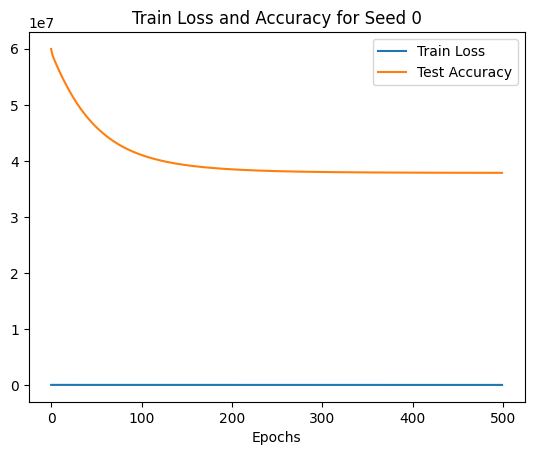

In [ ]:
# Function to plot data for a certain seed
def plot_loss_acc(plot_data, index):
  plt.figure(index)
  ax = plt.gca()

  # change plot_data into a np array
  data = np.array(plot_data)
  x = data[:,0]           # first column is the epoch count
  train_loss = data[:,1]  # second column is train loss
  train_acc = data[:,2]   # 3rd column is train accuracy
  test_acc = data[:,3]    # 4th column is test accuracy

  ax.plot(train_loss, label = 'Train Loss')
  ax.plot(test_acc, label = 'Test Accuracy')
  ax.legend()
  # ax.set_ylim([0.0, 1.0])
  plt.xlabel('Epochs')
  plt.title('Train Loss and Accuracy for Seed %d' %index)

# train model using 5 random seeds
train_accuracies = []
test_accuracies = []
epochs = 500
for i in range(1):
  plot_data=train_model(net, train_loader, test_loader, epochs, i)

  train_accuracies.append(np.array(plot_data)[(epochs - 1),2])
  test_accuracies.append(np.array(plot_data)[(epochs - 1),3])

  plot_loss_acc(plot_data, i)

In [ ]:
# Test accuracy on test set
print("train mean:", np.mean(train_accuracies))
print("train stddv:", np.std(train_accuracies))
print("test mean:", np.mean(test_accuracies))
print("test stddv:", np.std(test_accuracies))

train mean: 124731768.0
train stddv: 0.0
test mean: 37874228.0
test stddv: 0.0
